In [1]:
from scipy import misc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io
import warnings
warnings.filterwarnings('ignore')

# Preliminary Data Exploration of Vandalism on r/place

### Data requirements & Dependencies

The final image of place, and the community corrected version of it are both in the resources folder present on the repo. The CSV of all tiles placed through all the 72h is too big to be on the repository, so for this notebook to work, it needs to get downloaded [here](https://storage.googleapis.com/place_events/tile_placements.csv.gz) and put in a "dataset" folder at the root of the project

In [2]:
#full dataset gzipped found here : https://www.reddit.com/r/redditdata/comments/6640ru/place_datasets_april_fools_2017/
dataset = pd.read_csv("dataset/tile_placements.csv")
dataset.head(10)

,ts,user,x_coordinate,y_coordinate,color
0,1491167838000,c2Md9m4QckH8M+lhNh9btgoiFDk=,326,258,0
1,1491171651000,5KjCuLCk/VTXBIgaszopYecZ3uU=,190,791,0
2,1491105072000,toyjOAoAZMtlGZ3hXm5/LYsi+iA=,1,753,0
3,1491235861000,TGENUMJ6VmaBRr8ae9yP0MWQ66g=,233,931,0
4,1491163179000,usR8PLvN90gdivTbszEqhvPcXI4=,526,663,0
5,1491049593000,PhCeV35qg+Kd4HZH2A8YsmwE65w=,578,327,0
6,1491144746000,h36EHV8mxPdVf6/KSVcVJdQD+3g=,555,330,0
7,1491233125000,Fs34pA4xcfKSvw/c+kS+P31aB+s=,906,95,0
8,1491149990000,JSi4ekmizWOUcjae6TFFCLUGeH8=,862,480,0
9,1491098731000,otYEXzF2K9RLO0VCBSS/bpOcek4=,404,959,0


In [3]:
len(dataset)

16559897

### First Statistics of Vandalism on the Final Result
Comparing pixels of the final image and the corrected one allows us to already look at how much pixel were vandalised in absolute at the closing of r/place


In [4]:
canvaFinal = misc.imread("resources/canvaFinal.png")
canvaCorr = misc.imread("resources/canvaCorrected.png")

#The color value are indexed correctly in the array. Values Found on the same 
colors = [
    '#FFFFFF',
    '#E4E4E4',
    '#888888',
    '#222222',
    '#FFA7D1',
    '#E50000',
    '#E59500',
    '#A06A42',
    '#E5D900',
    '#94E044',
    '#02BE01',
    '#00E5F0',
    '#0083C7',
    '#0000EA',
    '#E04AFF',
    '#820080'
]

def RGBToHex(value):
    return ('#%02x%02x%02x' % (value[0], value[1], value[2])).upper()

def HexToRGB(hexStr):
    return tuple(int(hexStr.strip('#')[i:i+2], 16) for i in (0, 2 ,4)) 

def arePixEq(p1, p2):
    match = True
    for k in range(3):
        match = match and p1[k] == p2[k]
    return match
        
total = 1000**2
count = 0
'''
Further analysis later on hit buckets of pixels show that both the corrected image
and the final one use the same RGB components. However that's not the case between
the two image and the dataset.
'''
for i in range(999):
    for j in range(999):
        canvaFinal[i][j]
        pix2 = canvaCorr[i][j]
        if not arePixEq(canvaFinal[i][j], canvaCorr[i][j]):
            count += 1

print("Number of pixel vandalised : %d"%(count))
print("Percentage of pixel vandalised : %lf"%((100*count)/total))

Number of pixel vandalised : 72681
Percentage of pixel vandalised : 7.268100


### Mismatched color detection and correction 
Upon inspection, it came to light that the color code given for the dataset does not match all the pixel color found on both the PNG images. The two cells below will try to correct this follwing this idea : 
* The first will identify which color are not found in the dataset for both PNGs
* The second will compare all the mismatched color from the PNG with the ones of the dataset missing from the PNG, to identify which one they are likely refering to.


In [5]:
#init of all hit buckets
mismatches = {}
colorsHitF = {}
colorsHitC = {}

for c in colors:
    colorsHitF[c] = 0
    
for c in colors:
    colorsHitC[c] = 0

for i in range(999):
    for j in range(999):
        fPix = canvaCorr[i][j]
        cPix = canvaFinal[i][j]
        convF = RGBToHex(fPix)
        convC = RGBToHex(cPix)
        if convF not in colors:
            cAddF = 'f'+convF
            if cAddF in mismatches.keys():
                mismatches[cAddF] += 1
            else:
                mismatches[cAddF] = 1
        else:
            colorsHitF[convF] += 1
        if convC not in colors:
            cAddC = 'c'+convC
            if convC in mismatches.keys():
                mismatches[cAddC] += 1
            else:
                mismatches[cAddC] = 1
        else:
            colorsHitC[convC] += 1
            
mismatches
for k,v in mismatches.items():
    if k[0] == 'c':
        print("Color %s from the corrected canva was mismatched %d times"%(k[1:], v))
    else:
        print("Color %s from the final canva was mismatched %d times"%(k[1:], v))
    
print("HitBucket content of Final Canva")
for k,v in colorsHitF.items():
    print("\tColor %s was detected %d times"%(k, v))
    
print("HitBucket content of Corrected Canva")
for k,v in colorsHitC.items():
    print("\tColor %s was detected %d times"%(k, v))


Color #00D3DD from the corrected canva was mismatched 1 times
Color #00D3DD from the final canva was mismatched 30425 times
Color #CF6EE4 from the final canva was mismatched 13280 times
Color #CF6EE4 from the corrected canva was mismatched 1 times
HitBucket content of Final Canva
	Color #FFFFFF was detected 153789 times
	Color #E4E4E4 was detected 27185 times
	Color #888888 was detected 25183 times
	Color #222222 was detected 257353 times
	Color #FFA7D1 was detected 29123 times
	Color #E50000 was detected 120132 times
	Color #E59500 was detected 57168 times
	Color #A06A42 was detected 17570 times
	Color #E5D900 was detected 63897 times
	Color #94E044 was detected 16800 times
	Color #02BE01 was detected 39484 times
	Color #00E5F0 was detected 0 times
	Color #0083C7 was detected 33516 times
	Color #0000EA was detected 93438 times
	Color #E04AFF was detected 0 times
	Color #820080 was detected 19658 times
HitBucket content of Corrected Canva
	Color #FFFFFF was detected 154430 times
	Color

#00E5F0(dataset) vs (canvas)#00D3DD


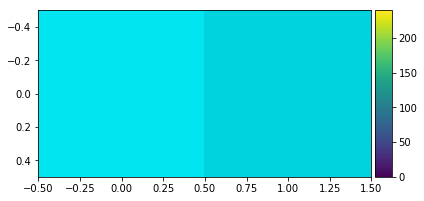

#00E5F0(dataset) vs (canvas)#CF6EE4


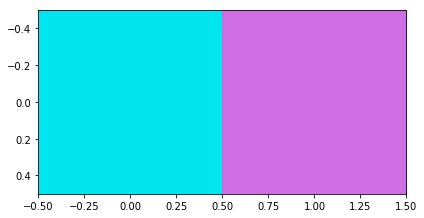

#E04AFF(dataset) vs (canvas)#00D3DD


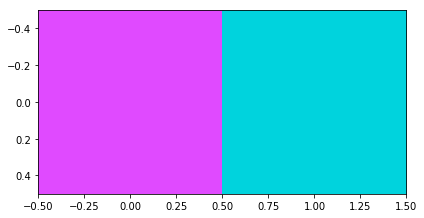

#E04AFF(dataset) vs (canvas)#CF6EE4


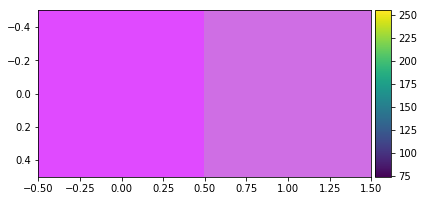

In [6]:
absentColors = ['#00E5F0','#E04AFF']
mismatchColors = ['#00D3DD','#CF6EE4']

for a in absentColors:
    for m in mismatchColors:
        print(a+ "(dataset) vs (canvas)" +m)
        arr = np.array([[HexToRGB(a), HexToRGB(m)]], dtype=np.uint8)
        io.imshow(arr)
        plt.show()


Upon those results, it can safely be assumed that the color #00D3DD should be mapped to #00E5F0 (color code 11 in the array) and the color #CF6EE4 should be mapped to  #E04AFF (color code 14 in the array)

In [7]:
colorCodeTranslation = {}
idx = 0
while(idx < len(colors)):
    colorCodeTranslation[colors[idx]] = idx
    idx += 1

colorCodeTranslation['#00D3DD'] = 11
colorCodeTranslation['#CF6EE4'] = 14
colorCodeTranslation

{'#0000EA': 13,
 '#0083C7': 12,
 '#00D3DD': 11,
 '#00E5F0': 11,
 '#02BE01': 10,
 '#222222': 3,
 '#820080': 15,
 '#888888': 2,
 '#94E044': 9,
 '#A06A42': 7,
 '#CF6EE4': 14,
 '#E04AFF': 14,
 '#E4E4E4': 1,
 '#E50000': 5,
 '#E59500': 6,
 '#E5D900': 8,
 '#FFA7D1': 4,
 '#FFFFFF': 0}

### Processing Data for next steps
To work with the dataset, we need a version of the image which contains only the correct color code :

In [8]:
canvaCorrCode = [[colorCodeTranslation[RGBToHex(j)] for j in i] for i in canvaCorr]
np.shape(canvaCorrCode)

(1000, 1000)

In [9]:
np.array(canvaCorrCode).min()

0

Now, the idea would be to analyse raw vandalism for each pixel as a whole, i.e. count all numbers differents from the one on the corrected canvas, and put them in a 1000\*1000 matrix and/or a DataFrame

In [10]:
heatMap = np.zeros(shape=(1000, 1000))
def pixDeviate(row):
    if not couleur == canvaCorrCode[x][y]:
        return True
    else:
        return False

def getRefColor(row):
    x = int(row['x_coordinate'])
    y = int(row['y_coordinate'])
    if x > 999:
        return -1
    elif y > 999:
        return -1
    else:
        return canvaCorrCode[x][y]

dataset['refColor'] = dataset.apply(getRefColor, axis=1)

In [11]:
filteredData = dataset[(dataset.color  != dataset.refColor) & (dataset.refColor  != -1)]

In [12]:
def fillArray(row):
    x = row['x_coordinate']
    y = row['y_coordinate']
    count = row['counts']
    heatMap[x][y] += count
res = filteredData.groupby(['x_coordinate', 'y_coordinate']).size().reset_index(name='counts')
res.apply(fillArray, axis=1)

heatMap

array([[ 4898.,   634.,   214., ...,   219.,   579.,  3183.],
       [  845.,  1680.,   280., ...,   424.,   895.,   760.],
       [  246.,   639.,   351., ...,   401.,   229.,   237.],
       ...,
       [ 1107.,   276.,   402., ...,   506.,   489.,   681.],
       [  857.,   946.,   296., ...,   338.,  1690.,  2942.],
       [ 4711.,  1151.,   411., ...,   490.,  2254., 16578.]])

In [13]:
heatMapClipped = heatMap.clip(0, np.percentile(heatMap, 99))

In [14]:
wrongPix = dataset[(dataset.x_coordinate > 999) | (dataset.y_coordinate > 999)]
len(wrongPix)

3256

In [15]:
maxCollision = np.amax(heatMap)
minCollisions = np.amin(heatMap)
print(maxCollision)
print(minCollisions)

16578.0
0.0


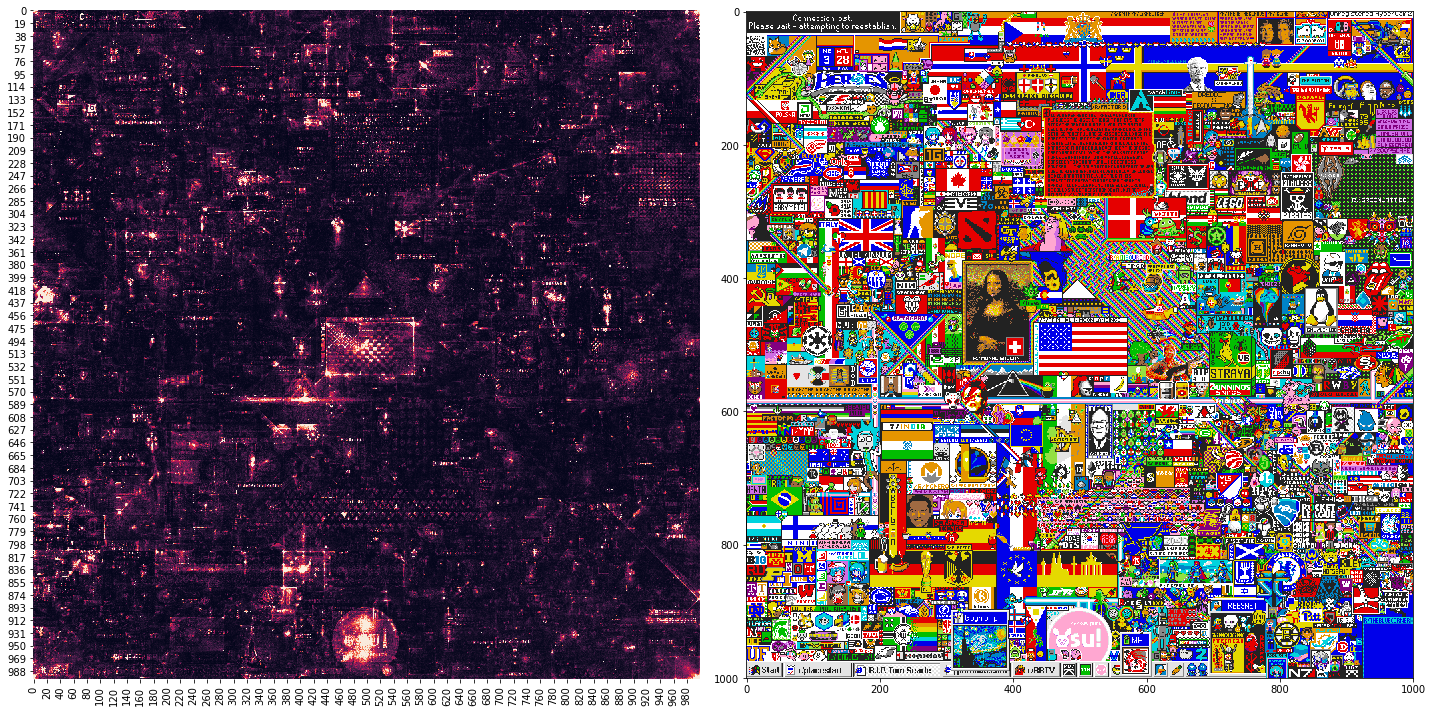

In [16]:
import seaborn as sns
fig, ax = plt.subplots(1,2, figsize=(20,10))    
ax = sns.heatmap(heatMapClipped.T, ax=ax[0], cbar=False)
io.imshow(canvaCorr)
plt.show()
#only the extreme lower right corner pixel is another color....

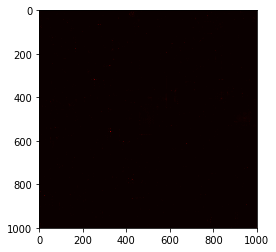

In [17]:
plt.imshow(heatMap, cmap='hot', interpolation='nearest')
plt.show()

### Analysing America's flag lifetime

In [23]:
#Filtering to get only data about the america flag at the center
xMin = 431
xMax = 572
yMin = 467
yMax = 547

AmericaFuckYeah = filteredData[(filteredData.x_coordinate > xMin) & (filteredData.x_coordinate < xMax) & \
                          (filteredData.y_coordinate > yMin) & (filteredData.y_coordinate < yMax)]

#### Heatmap of America flag only (to check if above boundaries seem correct)

In [19]:
heatMapUSA = np.zeros(shape=(1000, 1000))
def fillUSArray(row):
    x = row['x_coordinate']
    y = row['y_coordinate']
    count = row['counts']
    heatMapUSA[x][y] += count

res = AmericaFuckYeah.groupby(['x_coordinate', 'y_coordinate']).size().reset_index(name='counts')
res.apply(fillUSArray, axis=1)
print()

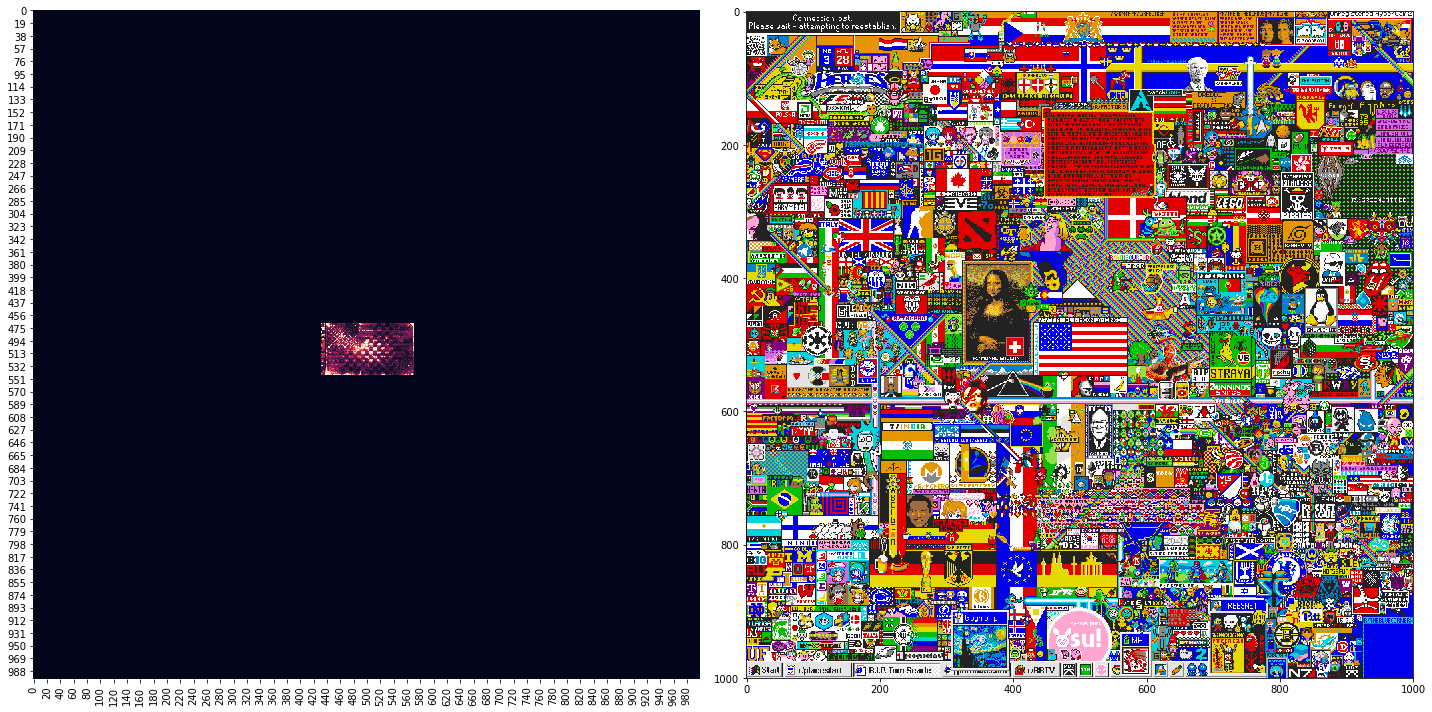

In [20]:
heatMapClippedUSA = heatMapUSA.clip(0, np.percentile(heatMap, 99))
fig, ax = plt.subplots(1,2, figsize=(20,10))    
ax = sns.heatmap(heatMapClippedUSA.T, ax=ax[0], cbar=False)
io.imshow(canvaCorr)
plt.show()

In [48]:
###Getting the america filtered version of the dataset only
AmericaDf = dataset[(dataset.x_coordinate > xMin) & (dataset.x_coordinate < xMax) & \
                          (dataset.y_coordinate > yMin) & (dataset.y_coordinate < yMax)]

In [54]:
AmericaDf['isCorrect'] = AmericaDf.apply(lambda row: 1 if int(row['color']) == int(row['refColor']) else 0, axis=1)

In [57]:
AmericaDf['isCorrect'].min()
AmericaDf

,ts,user,x_coordinate,y_coordinate,color,refColor,isCorrect
14,1491233043000,2Y/qRCnGZRzlW2yOz6kVrqs8bfo=,520,486,0,5,0
41,1491144410000,lO8eEmsjClvOYTTKax7KgEU3Trk=,464,500,0,3,0
51,1491195323000,oytWOniRRsadNabhS/jEHga3Ayg=,463,513,0,0,1
54,1491055406000,vKilvTmFqemKnwM7ebllssKGIsw=,463,484,0,0,1
62,1491155762000,s8bFoC0GNY2skWMicpvsmNchuyI=,570,474,0,0,1
69,1491157813000,6V0gDWCjK858htbNnI0g25hRLK8=,455,485,0,4,0
72,1491109263000,Z8hh7J607z9xGYhw6YMM1u0FVZg=,477,515,0,0,1
79,1491130431000,U++EJBjRQ6P68PP5LbYAXwCNZ2E=,492,501,0,5,0
86,1491106572000,/3b09BogLZtRgnrqDhy4N95n4fw=,560,526,0,4,0
102,1491109079000,eGsdmjsMqslUOo5em0rI6B5OS+U=,507,512,0,5,0


To have better temporal resolution, (as at most only 22 modifications were issued on a same timestamp for a given time), we will map every timestamp into the closest minutes it represents.

In [78]:
minStmp = dataset['ts'].min()
maxStmp = dataset['ts'].max()
minIn72Hrs = 72

AmericaDf['tsAbsMin'] = AmericaDf.apply(lambda row: int((int(row['ts'])-minStmp)/(minIn72Hrs*1000)), axis=1)
print('maxVale : %d, minValue : %d, ts diff : %d, ts dif divided by 72 should give 1000 : %lf'%(maxStmp/1000, minStmp/1000, (maxStmp-minStmp)/1000, (maxStmp-minStmp)/72))

maxVale : 1491238734, minValue : 1490918688, ts diff : 320046, ts dif divided by 72 should give 1000 : 4445083.333333


In [79]:
resMinutes = AmericaDf[['tsAbsMin', 'isCorrect']].groupby(by='tsAbsMin').agg(['count', 'sum'])
resMinutes

isCorrect     
             count  sum
tsAbsMin               
0                2    0
1                1    0
9                5    0
10               3    0
11               2    0
12               4    0
13               6    0
14               6    0
15               1    0
26               1    0
27               1    0
29               1    0
33               1    0
34               1    0
35               1    0
37               1    1
38               4    0
39               1    0
40               2    0
41               1    0
43               1    0
52               1    1
70               4    0
73               1    0
74               6    0
75               2    0
77               1    0
78               3    0
81               2    0
111              1    0
...            ...  ...
4416           370  113
4417           309   96
4418           304  104
4419           350  109
4420           365   96
4421           370   91
4422           317   83
4423           315   89
4424           390  135
4425           383  115
4426           339   97
4427           331   85
4428           328  119
4429           376  115
4430           374  100
4431           361  114
4432           375  127
4433           339  115
4434           391  115
4435           326  102
4436           330   99
4437           371  117
4438           326   94
4439           390  127
4440           366  106
4441           372  127
4442           384  109
4443           221   54
4444           150   42
4445             1    0

[3676 rows x 2 columns]

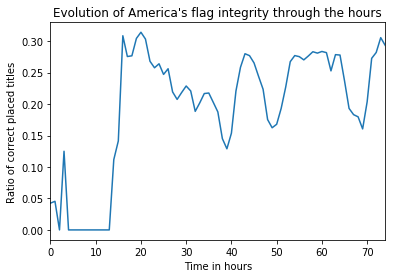

In [77]:
res['percRight'] = res.apply(lambda row: row['isCorrect']['sum']/row['isCorrect']['count'],axis=1)
res['percRight'].plot()
plt.title('Evolution of America\'s flag integrity through the hours')
plt.xlabel('Time in hours')
plt.ylabel('Ratio of correct placed titles')
plt.show()


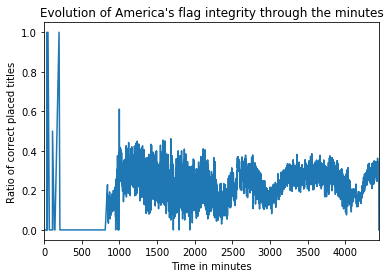

In [82]:
resMinutes['percRight'] = resMinutes.apply(lambda row: row['isCorrect']['sum']/row['isCorrect']['count'],axis=1)
resMinutes['percRight'].plot()
plt.title('Evolution of America\'s flag integrity through the minutes')
plt.xlabel('Time in minutes')
plt.ylabel('Ratio of correct placed titles')
plt.show()